In [ ]:
import os
import zipfile
import tensorflow as tf

# Download dataset
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL)

# Extract manually (this is the key fix!)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/tmp')

# Now define paths correctly
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(validation_dir, 'cats')
val_dogs_dir = os.path.join(validation_dir, 'dogs')

# Count images
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))

print('✅ Download & extraction successful!')
print('Training cats:', num_cats_train)
print('Training dogs:', num_dogs_train)
print('Validation cats:', num_cats_val)
print('Validation dogs:', num_dogs_val)


✅ Download & extraction successful!
Training cats: 1000
Training dogs: 1000
Validation cats: 500
Validation dogs: 500


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Rescale pixel values (0–255 to 0–1)
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


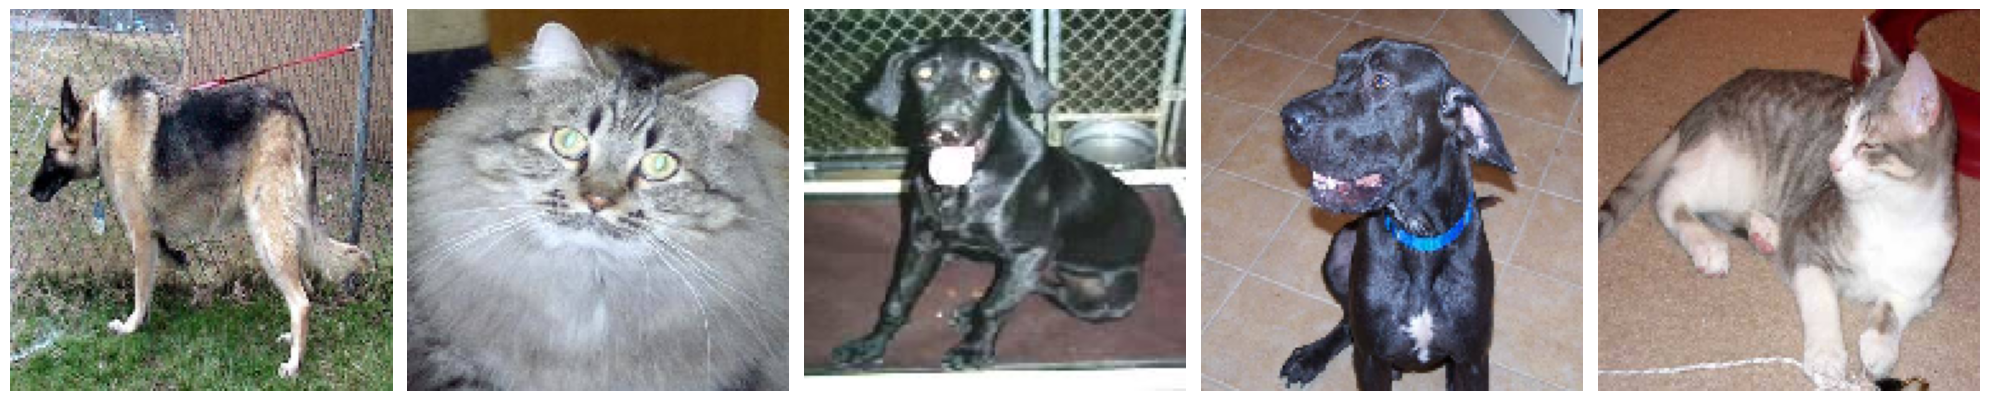

In [ ]:
import matplotlib.pyplot as plt

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rebuild training data generator using augmented generator
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output: cat or dog
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 15

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // BATCH_SIZE
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5128 - loss: 0.7736

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 310ms/step - accuracy: 0.5127 - loss: 0.7727 - val_accuracy: 0.5081 - val_loss: 0.6843
Epoch 2/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4688 - loss: 0.6950

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4688 - loss: 0.6950 - val_accuracy: 0.5464 - val_loss: 0.6855
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.5212 - loss: 0.6905 - val_accuracy: 0.5938 - val_loss: 0.6523
Epoch 4/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6562 - loss: 0.6636

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6562 - loss: 0.6636 - val_accuracy: 0.5373 - val_loss: 0.6837
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.5812 - loss: 0.6752 - val_accuracy: 0.6210 - val_loss: 0.6600
Epoch 6/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6562 - loss: 0.6263

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6562 - loss: 0.6263 - val_accuracy: 0.6331 - val_loss: 0.6587
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.6011 - loss: 0.6614 - val_accuracy: 0.6250 - val_loss: 0.6532
Epoch 8/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6250 - loss: 0.6649

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6250 - loss: 0.6649 - val_accuracy: 0.6522 - val_loss: 0.6468
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 261ms/step - accuracy: 0.6165 - loss: 0.6532 - val_accuracy: 0.6593 - val_loss: 0.6062
Epoch 10/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5938 - loss: 0.6263

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5938 - loss: 0.6263 - val_accuracy: 0.6704 - val_loss: 0.6147
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.6351 - loss: 0.6419 - val_accuracy: 0.6845 - val_loss: 0.5914
Epoch 12/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6875 - loss: 0.5992

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6875 - loss: 0.5992 - val_accuracy: 0.6845 - val_loss: 0.5979
Epoch 13/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.6589 - loss: 0.6231 - val_accuracy: 0.6804 - val_loss: 0.5827
Epoch 14/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6875 - loss: 0.5556

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6875 - loss: 0.5556 - val_accuracy: 0.6815 - val_loss: 0.5870
Epoch 15/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 361ms/step - accuracy: 0.6856 - loss: 0.5928 - val_accuracy: 0.6946 - val_loss: 0.5695


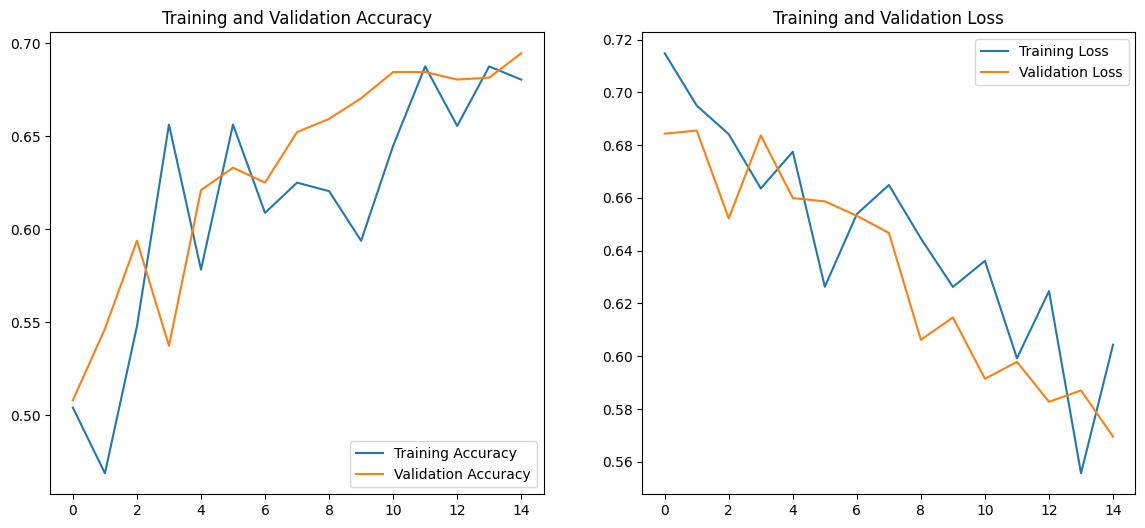

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


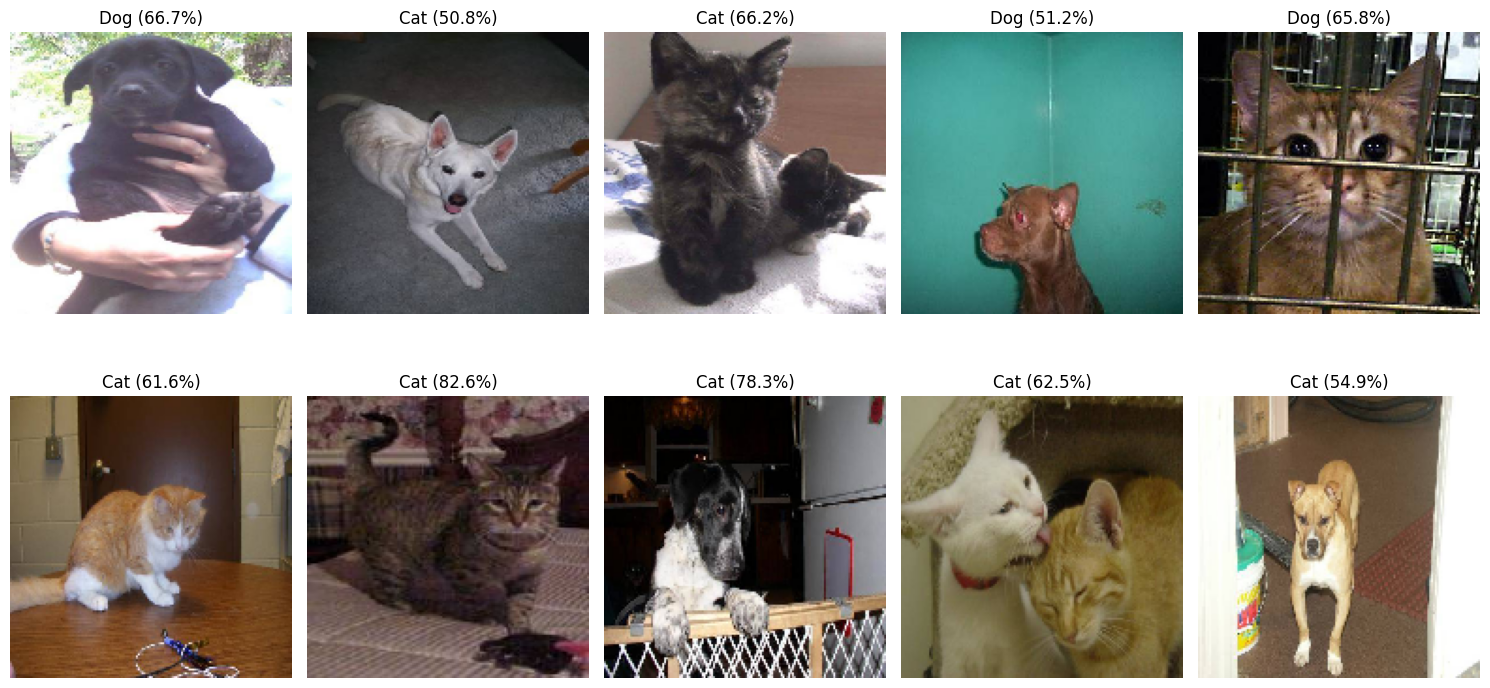

In [ ]:
# Get a batch of validation images
test_images, test_labels = next(val_data_gen)

# Predict probabilities (values between 0 and 1)
pred_probs = model.predict(test_images)
pred_probs = pred_probs.flatten()  # Convert to 1D

# Convert probabilities to "Cat"/"Dog" labels with % confidence
def get_label(prob):
    if prob > 0.5:
        return f'Dog ({prob*100:.1f}%)'
    else:
        return f'Cat ({(1 - prob)*100:.1f}%)'

# Plot with predictions
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(get_label(pred_probs[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()
